# Push SWAG

## Introduction

In this notebook, we run SWAG using PusH. SWAG stands for Stochastic Weight Averaging Gaussian, and it is used to build a distribution of parameters for a pre trained network by averaging parameter values over a set number of swag epochs. We begin by training a standard neural network for some number of epochs, then we start tracking and calculating the first and second moments of our model's parameters. The first moment is a running average of our parameters, updated after each swag epoch. The second moment is simply the first moment squared. After training for swag epochs, we use the first and second moments to sample parameter states.

To get an inference result, we choose to sample say 20 parameter states, and average the predictions from these 20. The first and second moment defines our distribution to sample from, and can be a simple gaussian.

### Dataset

For illustrative purposes, we create a random dataset with $N$ points of dimension $D$.

In [1]:
from bdl import SineDataset
import math

D = 1
batch_size = 12
N = 64
train_begin_radians = -2 * math.pi
train_end_radians = 2 * math.pi
test_begin_radians = -4 * math.pi
test_end_radians = 4 * math.pi
dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)
oos_dataset = SineDataset(batch_size, N, D, test_begin_radians, test_end_radians)

```py
class SineDataset(Dataset):
    def __init__(self, batch_size, N, D, begin, end):
        self.xs = torch.linspace(begin * math.pi, end * math.pi, batch_size * N * D).reshape(batch_size * N, D)
        self.ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

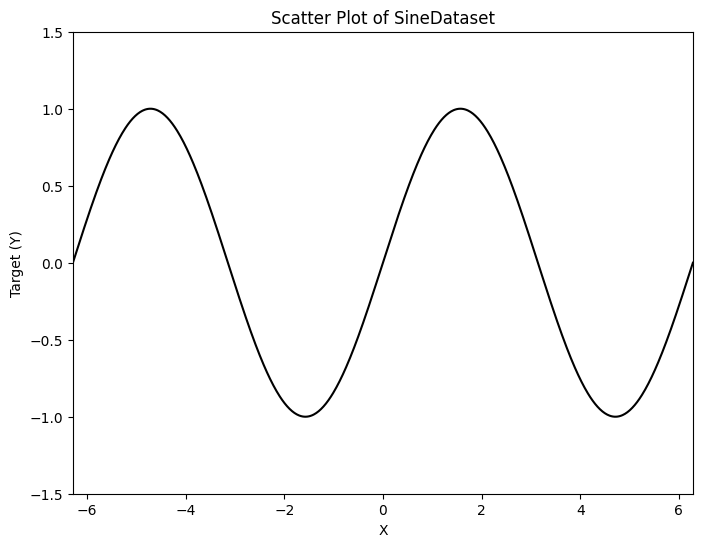

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

### Neural Network

We create a simple neural network (NN). This NN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. 

In [3]:
from bdl import MiniNN
from bdl import BiggerNN

### Training a SWAG Neural Network


In [4]:
import torch
from torch.utils.data import DataLoader
import push.bayes.swag

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 64
L = 4
num_ensembles = 2
swag_epochs = 2
pretrain_epochs = 2
particles = 1
cache_size = 4
view_size = 2

model = push.bayes.swag.train_mswag(
    dataloader,
    torch.nn.MSELoss(),
    pretrain_epochs,
    swag_epochs,
    particles,
    cache_size,
    view_size,
    BiggerNN, L, input_dim, output_dim, hidden_dim,
)

mean_preds = model.posterior_pred(dataloader, loss_fn=torch.nn.MSELoss(), num_samples=20, scale=1.0, var_clamp=1e-30)

  0%|          | 0/2 [00:00<?, ?it/s]

Average epoch loss tensor(0.5116)


 50%|█████     | 1/2 [00:00<00:00,  1.82it/s]

Average epoch loss tensor(0.5087)


  0%|          | 0/2 [00:00<?, ?it/s]

Average epoch loss tensor(0.5057)


 50%|█████     | 1/2 [00:00<00:00,  2.16it/s]

Average epoch loss tensor(0.5027)


 56%|█████▋    | 36/64 [00:00<00:00, 357.20it/s]

fut._fid:  1


100%|██████████| 64/64 [00:00<00:00, 360.53it/s]


In [5]:
mean_preds

tensor([[[-0.0888],
         [-0.0884],
         [-0.0910],
         [-0.0882],
         [-0.0895],
         [-0.0908],
         [-0.0924],
         [-0.0893],
         [-0.0884],
         [-0.0905],
         [-0.0903],
         [-0.0919]],

        [[-0.0882],
         [-0.0884],
         [-0.0874],
         [-0.0896],
         [-0.0867],
         [-0.0896],
         [-0.0900],
         [-0.0894],
         [-0.0881],
         [-0.0890],
         [-0.0870],
         [-0.0906]],

        [[-0.0873],
         [-0.0878],
         [-0.0885],
         [-0.0902],
         [-0.0884],
         [-0.0868],
         [-0.0912],
         [-0.0896],
         [-0.0906],
         [-0.0876],
         [-0.0880],
         [-0.0881]],

        [[-0.0862],
         [-0.0863],
         [-0.0892],
         [-0.0873],
         [-0.0900],
         [-0.0896],
         [-0.0890],
         [-0.0904],
         [-0.0878],
         [-0.0887],
         [-0.0870],
         [-0.0894]],

        [[-0.0873],
         [-0